In [1]:
%%bash

gsutil cp -r gs://ot-snapshots/link-2/output/cooccurrences/part-00000-0883439b-5aa1-4062-a96f-fc871cb218b5-c000.snappy.parquet \
    /Users/dsuveges/project_data/epmc_evidence/

Copying gs://ot-snapshots/link-2/output/cooccurrences/part-00000-0883439b-5aa1-4062-a96f-fc871cb218b5-c000.snappy.parquet...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][231.4 MiB/231.4 MiB]    1.2 MiB/s                                   
Operation completed over 1 objects/231.4 MiB.                                    


In [2]:
import pyspark.sql
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import re

global spark

# SparkContext.setSystemProperty('spark.executor.memory', '20g')

spark = (pyspark.sql.SparkSession
    .builder
    .appName("phenodigm_parser")
    .config("spark.executor.memory", '10g')
     .config("spark.driver.bindAddress", "localhost")
    .config("spark.driver.memory", '10g')
    .getOrCreate()
)

#   

partitionKeys = ['pmid', 'targetFromSourceId', 'diseaseFromSourceMappedId']
print('Spark version: ', spark.version)
epmc_cooc_file = '/Users/dsuveges/project_data/epmc_evidence/cooccurrences/*'
# cooc_df = (
#     spark.read.parquet(epmc_cooc_file)
#     .filter((col('type') == "GP-DS") & (col('isMapped') == True) & (col('pmid') != ""))
#     .withColumnRenamed("keywordId1", "targetFromSourceId")
#     .withColumnRenamed("keywordId2", "diseaseFromSourceMappedId")
#     .withColumnRenamed("label1", "targetFromSource")
#     .withColumnRenamed("label2", "diseaseFromSource")
#     .dropDuplicates(partitionKeys)
#     .filter(col('targetFromSource') == '(')
#     .select('pmid', 'targetFromSource', 'targetFromSourceId', 'diseaseFromSourceMappedId', 'section', 'evidence_score')
#     .toPandas()
# )

partitionKeys = ['pmid', 'keywordId1', 'keywordId2']

cooc_df = (
    spark.read.json(epmc_cooc_file)
    .filter((col('type') == "GP-DS") & (col('isMapped') == True) & (col('pmid') != "") & (col('label1') == '('))
    .dropDuplicates(partitionKeys)
    .write.json('weird_names.json')
)


# 'pmid',
#  'pubDate',
#  'organisms',
#  'section',
#  'text',
#  'association',
#  'end1',
#  'end2',
#  'evidence_score',
#  'targetFromSource',
#  'targetFromSourceId',
#  'diseaseFromSource',
#  'diseaseFromSourceMappedId',
#  'relation',
#  'start1',
#  'start2',
#  'type',
#  'type1',
#  'type2',
#  'isMapped'
print(len(cooc_df))
cooc_df.head()

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.AssertionError: assertion failed: Expected hostname (not IP) but got fe80:0:0:0:aede:48ff:fe00:1122%4
	at scala.Predef$.assert(Predef.scala:223)
	at org.apache.spark.util.Utils$.checkHost(Utils.scala:1030)
	at org.apache.spark.executor.Executor.<init>(Executor.scala:86)
	at org.apache.spark.scheduler.local.LocalEndpoint.<init>(LocalSchedulerBackend.scala:64)
	at org.apache.spark.scheduler.local.LocalSchedulerBackend.start(LocalSchedulerBackend.scala:132)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:201)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:550)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [3]:
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

import re

global spark

# SparkContext.setSystemProperty('spark.executor.memory', '20g')

sparkConf = (SparkConf()
         .set("spark.driver.memory", "15g")
         .set("spark.executor.memory", "15g")
         .set("spark.driver.maxResultSize", "0")
         .set("spark.debug.maxToStringFields", "2000")
         .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
         )
spark = (
    SparkSession.builder
        .config(conf=sparkConf)
         .config("spark.driver.bindAddress", "localhost")
        .master('local[*]')
        .getOrCreate()
)

cooccurrenceFile = '/Users/dsuveges/project_data/epmc_evidence/cooccurrences/*'
outputFile = '2021.03.18_epmc.json.gz'

partitionKeys = ['pmid', 'targetFromSourceId', 'diseaseFromSourceMappedId']
w = Window.partitionBy(*partitionKeys)
(
    # Reading file:
    spark.read.json(cooccurrenceFile)

    # Filtering for diases/target cooccurrences:
    .filter((col('type') == "GP-DS") & (col('isMapped') == True) & (col('pmid') != ""))

    # Renaming columns:
    .withColumnRenamed("keywordId1", "targetFromSourceId")
    .withColumnRenamed("keywordId2", "diseaseFromSourceMappedId")
    .withColumnRenamed("label1", "targetFromSource")
    .withColumnRenamed("label2", "diseaseFromSource")

        # collect sets of field values per window aggregation in w with keys partitionKeys
    .withColumn('textMiningSentences', collect_set(
            struct(
                col("text"),
                col('start1').alias('tStart'),
                col("end1").alias('tEnd'),
                col('start2').alias('dStart'),
                col("end2").alias('dEnd'),
                col('section')
            )).over(w)
        )
    .withColumn('resourceScore', sum(col('evidence_score')).over(w))
    .filter(col('resourceScore') >= 2)
    .dropDuplicates(partitionKeys)
    .withColumn("literature", array(col('pmid')))

    # Adding linteral columns:
    .withColumn('datasourceId',lit('europepmc'))
    .withColumn('datatypeId',lit('literature'))

    # Reorder columns:
    .select(["datasourceId", "datatypeId", "targetFromSource", "targetFromSourceId",'resourceScore',
            "diseaseFromSource","diseaseFromSourceMappedId","literature","textMiningSentences"])

    # Save output:
    .write.format('json').mode('overwrite').option('compression', 'gzip').save(outputFile)
)

Py4JJavaError: An error occurred while calling o151.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:226)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:178)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:121)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:944)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:944)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:396)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:380)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:269)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: Job 1 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:954)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:954)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2221)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2134)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:1967)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1357)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1967)
	at org.apache.spark.SparkContext.$anonfun$new$35(SparkContext.scala:626)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:195)
	... 32 more


In [66]:
# old_file = 'old_epmc_sample.json'
old_file = '/Users/dsuveges/project_data/ot/evidence_input/21.02/epmc/cttv025-25-01-2021.json.gz'
# cooc_df = (
#     spark.read.json(old_file)
#     .filter(size(col('evidence.literature_ref.mined_sentences')) == 1)
#     .withColumn("sentences", explode(col('evidence.literature_ref.mined_sentences')))
#     .select(col('unique_association_fields.target_id').alias('target_id'), 
#         col('unique_association_fields.publication_id').alias('publication_id'), 
#         col('unique_association_fields.disease_id').alias('disease_id'), 
#         col('evidence.resource_score.value').alias('score'),
#         col('evidence.literature_ref.mined_sentences').alias('sentences'),
#         col('sentences.section').alias('section'))
#     .toPandas()
# )

# cooc_df.head()


import pandas as pd
import json
import gzip

old_data = []

with gzip.open(old_file) as f:
    for line in f:
        data = json.loads(line)
#         if len(data['evidence']['literature_ref']['mined_sentences']) > 1:
#             continue 
            
        old_data.append({
            'target': data['target']['id'].split('/')[-1],
            'disease': data['disease']['id'].split('/')[-1],
            'paper': data['evidence']['unique_experiment_reference'].split('/')[-1],
            'score': data['evidence']['resource_score']['value'],
            'first_section': data['evidence']['literature_ref']['mined_sentences'][0]['section'],
            'sections': [x['section'] for x in data['evidence']['literature_ref']['mined_sentences']]
        })

old_df = pd.DataFrame(old_data)
print(f'Number of evidence: {len(old_df)}')
print(old_df.head())

27
   target         disease     paper  score first_section  \
0  O14813     EFO_1001985  11882252   15.2      abstract   
1  O14813  Orphanet_45358  11882252   12.2         title   
2  P01108     EFO_0000621  11922865    8.0         other   
3  P01138     EFO_0000239  11922865    8.4      abstract   
4  P01138     EFO_0000621  11922865    6.4         other   

                                            sections  
0  [abstract, abstract, abstract, other, other, o...  
1                                     [title, other]  
2  [other, other, other, other, other, other, oth...  
3                                  [abstract, other]  
4                                     [other, other]  


In [67]:
len(old_df)

7976568

In [69]:
old_df.first_section.value_counts()

abstract    5629820
title       1417215
other        817758
figure        64473
table         46586
appendix        716
Name: first_section, dtype: int64

In [74]:
old_df.loc[old_df.score > 100]

,target,disease,paper,score,first_section,sections
7928,Q9H293,EFO_0005741,16606667,107.8,abstract,"[abstract, abstract, figure, figure, figure, f..."
10125,Q8N474,EFO_0000182,17626620,149.0,title,"[title, abstract, abstract, abstract, abstract..."
15221,P29590,Orphanet_647,17030982,193.8,abstract,"[abstract, abstract, figure, figure, figure, f..."
20021,P00519,EFO_0004289,15939795,135.6,abstract,"[abstract, figure, figure, figure, figure, fig..."
20030,P11274,EFO_0004289,15939795,135.6,abstract,"[abstract, figure, figure, figure, figure, fig..."
...,...,...,...,...,...,...
1431574,P23470,EFO_0003060,33174523,115.0,title,"[title, abstract, abstract, abstract, abstract..."
1432104,Q11201,EFO_0000756,33203881,106.0,title,"[title, abstract, abstract, abstract, abstract..."
1432532,Q9H7M9,MONDO_0007254,33250890,102.6,title,"[title, abstract, abstract, abstract, abstract..."
1436681,Q8NE86,EFO_0003897,33235465,101.6,abstract,"[abstract, abstract, abstract, abstract, abstr..."


In [79]:
filtered = old_df.loc[old_df.paper == '33203881',['target', 'disease', 'score', 'paper']]

In [1]:
import pyspark.sql
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import re

global spark

# SparkContext.setSystemProperty('spark.executor.memory', '20g')

spark = (pyspark.sql.SparkSession
    .builder
    .appName("phenodigm_parser")
    .config("spark.executor.memory", '10g')
     .config("spark.driver.bindAddress", "localhost")
    .config("spark.driver.memory", '10g')
    .getOrCreate()
)

#  

In [49]:
df = (
    spark.read.json('/Users/dsuveges/project_data/ot/evidence_input/21.04/phenodigm-2021-03-24.json.gz')
    .withColumn("biologicalModelId", 
                when(col("biologicalModelId").startswith("MGI"), col("biologicalModelId")).otherwise(None))
    .write.format('json').mode('overwrite').option('compression', 'gzip').save('/Users/dsuveges/project_data/ot/evidence_input/21.04/phenodigm-2021-03-24_b.json.gz')
)

In [12]:
(
    spark.read.json('/Users/dsuveges/Downloads/part-00000-2aa22b2a-5c07-48ae-919d-9cc14eaa7da6-c000.json.gz')
    .printSchema()
)

root
 |-- datasourceId: string (nullable = true)
 |-- datatypeId: string (nullable = true)
 |-- diseaseFromSource: string (nullable = true)
 |-- diseaseFromSourceMappedId: string (nullable = true)
 |-- literature: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- resourceScore: double (nullable = true)
 |-- targetFromSource: string (nullable = true)
 |-- targetFromSourceId: string (nullable = true)
 |-- textMiningSentences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- dEnd: long (nullable = true)
 |    |    |-- dStart: long (nullable = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- tEnd: long (nullable = true)
 |    |    |-- tStart: long (nullable = true)
 |    |    |-- text: string (nullable = true)



In [7]:
df.show()

+--------------------+------------------+--------------------+
|                 col|targetFromSourceId|   diseaseFromSource|
+--------------------+------------------+--------------------+
|[, 108, 95, abstr...|   ENSG00000112715|      bladder tumors|
|[, 49, 35, abstra...|   ENSG00000112715|      bladder tumors|
|[, 83, 69, abstra...|   ENSG00000112715|      bladder tumors|
|[, 85, 69, title,...|   ENSG00000136997|    Burkitt lymphoma|
|[, 104, 88, abstr...|   ENSG00000136997|    Burkitt lymphoma|
|[, 183, 171, abst...|   ENSG00000118702|        hypoglycemia|
|[, 352, 349, abst...|   ENSG00000123384|acute myeloid leu...|
|[, 352, 349, abst...|   ENSG00000123384|acute myeloid leu...|
|[, 136, 114, titl...|   ENSG00000123384|acute myeloid leu...|
|[, 146, 143, abst...|   ENSG00000123384|acute myeloid leu...|
|[, 133, 130, abst...|   ENSG00000123384|acute myeloid leu...|
|[, 277, 274, abst...|   ENSG00000113161|                 CAD|
|[, 155, 144, abst...|   ENSG00000134184|         lung 

In [14]:
# (
#     spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/raw_epmc_cooc/part-00007-23c5c03e-7e4c-4e79-92da-e9bcb3eef403-c000.snappy.parquet')
#     .printSchema()
# )

root
 |-- pmid: string (nullable = true)
 |-- pubDate: string (nullable = true)
 |-- organisms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- section: string (nullable = true)
 |-- text: string (nullable = true)
 |-- association: struct (nullable = true)
 |    |-- Altered_Expression: double (nullable = true)
 |    |-- Any: double (nullable = true)
 |    |-- Genetic_Variation: double (nullable = true)
 |    |-- Negative: double (nullable = true)
 |    |-- Neutral: double (nullable = true)
 |    |-- No: double (nullable = true)
 |    |-- Positive: double (nullable = true)
 |    |-- Regulatory_modification: double (nullable = true)
 |    |-- Yes: double (nullable = true)
 |-- end1: long (nullable = true)
 |-- end2: long (nullable = true)
 |-- evidence_score: double (nullable = true)
 |-- label1: string (nullable = true)
 |-- keywordId1: string (nullable = true)
 |-- label2: string (nullable = true)
 |-- keywordId2: string (nullable = true)
 |-- relation: arr

In [23]:



(
    spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/raw_epmc_cooc/part-00007-23c5c03e-7e4c-4e79-92da-e9bcb3eef403-c000.snappy.parquet')
    .filter(
        (col('type') == "GP-DS") & # Filtering for gene/disease cooccurrence
        (col('isMapped') == True) & # Filtering for mapping
        (col('pmid') != "") &  # Filtering out missing pmids
        (col('label1') != "(") & # Filtering out this strange entity.
        (length(col('text')) > 500 )) # Sentence threshold is 500 
    .withColumn('text_lenght', length(col('text')))
    .select(col('text_lenght'),col('text'))
    .dropDuplicates()
    .count()
)

444

In [45]:
(
    spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/raw_epmc_cooc/part-00007-23c5c03e-7e4c-4e79-92da-e9bcb3eef403-c000.snappy.parquet')
    .filter(
        (col('type') == "GP-DS") & # Filtering for gene/disease cooccurrence
        (col('isMapped') == True) & # Filtering for mapping
        (col('pmid') != "") &  # Filtering out missing pmids
        (col('label1') != "(") & # Filtering out this strange entity.
        (length(col('text')) > 500 )) # Sentence threshold is 500 
    .groupby([col('text'), col('pmid')])
    .agg(
        first(col("section")).alias('section'),
        length(col('text')).alias('textLenght'),
        collect_set(struct(
            col('keywordId1').alias('targetFromSourceId'),
            col("keywordId2").alias('diseaseFromSourceMappedId'),
        )).alias('associations'),
        collect_set(struct(
            col('label1').alias('targetLabel'),
            col("label2").alias('diseaseLabel'),
        )).alias('cooccurrences')
    )
    .withColumn('associationCount', size(col('associations')))
    .withColumn('cooccurrenceCount', size(col('cooccurrences')))

    .coalesce(1).write.format('json').mode('overwrite').option('compression', 'gzip')
    .save('epmc_long_sentences.json.gz')
)


In [47]:
df = spark.read.json('epmc-longSentences-600-2021-03-25.json.gz')




In [48]:
df.show()



+----------------+--------------------+-----------------+--------------------+----------+--------------------+--------------------+----------+
|associationCount|        associations|cooccurrenceCount|       cooccurrences|      pmid|             section|                text|textLenght|
+----------------+--------------------+-----------------+--------------------+----------+--------------------+--------------------+----------+
|               6|[[MONDO_0008199, ...|                2|[[PD, Aromatase],...|PMC6993383|characteristics o...|(%) (N = 971)Stud...|      3131|
|              12|[[EFO_0000673, EN...|                2|[[prostate cancer...|PMC5681753|             results|(%) (missing = 14...|      1184|
|              24|[[EFO_0010133, EN...|               20|[[hypoglycemia, C...|PMC4480895|baseline patient ...|(%) 1,5 AG: 1,5 a...|       892|
|               1|[[EFO_0000249, EN...|                1|          [[AD, Aβ]]|PMC6805864|participant chara...|(%)73 (27.14)25 (...|       668|

In [58]:
df_slim = (
    df
    .select(
        col('textLenght'),
        col('pmid'),
        col('associationCount'),
        col('cooccurrenceCount')
    )
)

df_slim.describe('textLenght')
                 
                 
                 

DataFrame[summary: string, textLenght: string]

In [59]:
df_slim.describe('textLenght').show()

+-------+------------------+
|summary|        textLenght|
+-------+------------------+
|  count|            271215|
|   mean|1114.1172575263167|
| stddev|1016.5778698172317|
|    min|               601|
|    max|             90390|
+-------+------------------+



In [61]:
df_slim.select(col('pmid')).dropDuplicates().count()

164228

In [65]:
import pandas as pd 
import gzip
import json

data_list = []
keys = ['pmid', 'textLenght', 'associationCount', 'cooccurrenceCount']
with gzip.open('epmc-longSentences-600-2021-03-25.json.gz/part-00000-b7ea605c-7751-420c-91e4-04f798393f9f-c000.json.gz') as f:
    for line in f:
        data = json.loads(line)
        data_list.append({key : data[key] for key in keys})

pdf = pd.DataFrame(data_list)
pdf.head()

,pmid,textLenght,associationCount,cooccurrenceCount
0,PMC6993383,3131,6,2
1,PMC5681753,1184,12,2
2,PMC4480895,892,24,20
3,PMC6805864,668,1,1
4,PMC4885647,3248,11,12


In [79]:
len(pdf.loc[pdf.textLenght < 10000])

2673

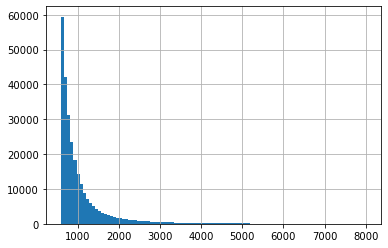

In [83]:
pdf.textLenght.loc[pdf.textLenght < 8000].hist(bins=100)

In [103]:
print(
    pdf
    .sort_values('associationCount', ascending=False)
    .head(10)
    .to_markdown(index=False)
)

| pmid       |   textLenght |   associationCount |   cooccurrenceCount |
|:-----------|-------------:|-------------------:|--------------------:|
| PMC7097195 |        11579 |              13180 |                 454 |
| PMC5785894 |         7420 |               9667 |                4750 |
| PMC7121660 |        13934 |               7560 |                5514 |
| PMC2652407 |         1452 |               6730 |                  25 |
| PMC3778950 |         9065 |               6621 |                5198 |
| PMC4516864 |        10923 |               5963 |                4764 |
| PMC5506596 |         7053 |               5296 |                2471 |
| PMC4540187 |         1105 |               5269 |                  43 |
| PMC7201962 |        23856 |               5026 |                4846 |
| PMC6026315 |         8138 |               4640 |                3509 |


In [118]:
6730 /25

269.2

In [121]:
c = len(pdf.loc[ pdf.associationCount/pdf.cooccurrenceCount >= 20])
print(f'{c} ({c/len(pdf)*100})')

69 (0.025441070737237986)


In [117]:
print(pdf.loc[pdf.cooccurrenceCount/pdf.associationCount >= 5].to_markdown(index=False))

| pmid       |   textLenght |   associationCount |   cooccurrenceCount |
|:-----------|-------------:|-------------------:|--------------------:|
| PMC6733778 |          619 |                  2 |                  10 |
| PMC7215562 |         1067 |                 10 |                  70 |
| PMC4083775 |          611 |                 12 |                  63 |
| PMC4306660 |         1041 |                  1 |                   6 |
| PMC4901088 |         3815 |                  2 |                  10 |
| PMC3920949 |         1306 |                  6 |                  30 |
| PMC7171711 |         1092 |                  1 |                   6 |
| PMC6525399 |          879 |                  5 |                  35 |
| PMC4602872 |          769 |                  1 |                   5 |
| PMC6825701 |          816 |                  1 |                   6 |
| PMC6881905 |          770 |                  2 |                  10 |
| PMC4790509 |         1120 |                  1 | 

In [133]:
len(
    pdf.loc[ pdf.associationCount/pdf.cooccurrenceCount >= 100]
    .assign(ambiguity = lambda x: x['associationCount'] / x['cooccurrenceCount'])
    .sort_values('ambiguity', ascending=False)
    .round(1)
)

29

In [142]:
(
    df
    .filter(col('textLenght') < 605)
    .select(col('pmid'), col('text'))
    .sample(False, .5, seed=23)
    .limit(20)
    .toPandas()
    .to_csv('sample_sentences.tsv', index=False, sep='\t')
)

In [145]:
sample = pd.read_csv('sample_sentences.tsv', sep='\t')
sample.WhatIsIt.value_counts()

Wrong split    14
List            3
Valid           3
Name: WhatIsIt, dtype: int64

In [148]:
pdf.associationCount.sum()

2623043

In [157]:
(
    df
    .select(explode(col('associations')).alias('associations'))
    .select(
        col('associations.diseaseFromSourceMappedId').alias('diseaseFromSourceMappedId'),
        col('associations.targetFromSourceId').alias('targetFromSourceId')
    )
    .dropDuplicates()
    .count()
)

955593

In [166]:
(
    df
    .filter(
        (col('pmid') == 'PMC4031205') & 
        (col('textLenght') == 938)
    )
    .select(
        col('pmid'),
        explode(col('associations')).alias('associations'),
        col('cooccurrences')
    )
    .select(
        col('pmid'),
        col('associations.diseaseFromSourceMappedId').alias('diseaseFromSourceMappedId'),
        col('associations.targetFromSourceId').alias('targetFromSourceId'),
        col('cooccurrences.diseaseLabel').alias('diseaseLabel'),
        col('cooccurrences.targetLabel').alias('targetLabel')
    )
    .show()
)

+----------+-------------------------+------------------+------------+-----------+
|      pmid|diseaseFromSourceMappedId|targetFromSourceId|diseaseLabel|targetLabel|
+----------+-------------------------+------------------+------------+-----------+
|PMC4031205|             Orphanet_646|   ENSG00000252798|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000238645|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000212266|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000239153|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000275001|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000277828|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000278055|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000277653|       [NPC]|       [S-]|
|PMC4031205|             Orphanet_646|   ENSG00000252096|       [NPC]|       [S-]|
|PMC

In [176]:
pdf_wrongmap = (
    df
    .filter(
        (col('pmid') == 'PMC4031205') & 
        (col('textLenght') == 938)
    )
    .withColumn('associations', explode(col('associations')))
    .withColumn('cooccurrences', explode(col('cooccurrences')))
    .select(
        col('pmid'),
        col('cooccurrences.diseaseLabel').alias('diseaseLabel'),
        col('associations.diseaseFromSourceMappedId').alias('diseaseFromSourceMappedId'),
        col('cooccurrences.targetLabel').alias('targetLabel'),
        col('associations.targetFromSourceId').alias('targetFromSourceId'),
    )
    .toPandas()
)

pdf_wrongmap.head()

,pmid,diseaseLabel,diseaseFromSourceMappedId,targetLabel,targetFromSourceId
0,PMC4031205,NPC,Orphanet_646,S-,ENSG00000252798
1,PMC4031205,NPC,Orphanet_646,S-,ENSG00000238645
2,PMC4031205,NPC,Orphanet_646,S-,ENSG00000212266
3,PMC4031205,NPC,Orphanet_646,S-,ENSG00000239153
4,PMC4031205,NPC,Orphanet_646,S-,ENSG00000275001


In [174]:
(
    df
    .filter(
        (col('pmid') == 'PMC4031205') & 
        (col('textLenght') == 938)
    )
    .select('text')
    .collect()
)

[Row(text='Serum levels of enzymes and signaling molecules have proven to be useful prognostic factors for various malignant tumors, facilitating the evaluation of disease development and prognosis.8–10 A previous study by Cheng et al showed that elevated serum lactate dehydrogenase (S-LDH) levels >410 U/L are associated with poor locoregional control of nonmetastatic, locally advanced NPC.11,12 Some other reports have suggested that elevated levels of S-LDH above the normal range predict poor prognosis in NPC.12–17 Jin et al reported that pretreatment S-LDH levels >245 U/L, which was the upper limit of the normal range in their study, were an independent prognostic factor for poor overall survival and progression-free survival in metastatic NPC.17 Li et al and Wang et al also showed that S-LDH levels >240 U/L, which was the upper limit of the normal range in their study, predicted poor prognosis in NPC without distant metastasis.10,15')]

In [179]:
raw = spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/raw_epmc_cooc/part-00007-23c5c03e-7e4c-4e79-92da-e9bcb3eef403-c000.snappy.parquet')
raw.printSchema()

root
 |-- pmid: string (nullable = true)
 |-- pubDate: string (nullable = true)
 |-- organisms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- section: string (nullable = true)
 |-- text: string (nullable = true)
 |-- association: struct (nullable = true)
 |    |-- Altered_Expression: double (nullable = true)
 |    |-- Any: double (nullable = true)
 |    |-- Genetic_Variation: double (nullable = true)
 |    |-- Negative: double (nullable = true)
 |    |-- Neutral: double (nullable = true)
 |    |-- No: double (nullable = true)
 |    |-- Positive: double (nullable = true)
 |    |-- Regulatory_modification: double (nullable = true)
 |    |-- Yes: double (nullable = true)
 |-- end1: long (nullable = true)
 |-- end2: long (nullable = true)
 |-- evidence_score: double (nullable = true)
 |-- label1: string (nullable = true)
 |-- keywordId1: string (nullable = true)
 |-- label2: string (nullable = true)
 |-- keywordId2: string (nullable = true)
 |-- relation: arr

In [184]:
input_file = '/Users/dsuveges/project_data/epmc_evidence/raw_epmc_cooc/part-00007-23c5c03e-7e4c-4e79-92da-e9bcb3eef403-c000.snappy.parquet'
(
    spark.read.parquet(input_file)
    .filter(
        (col('type') == "GP-DS") & # Filtering for gene/disease cooccurrence
        (col('isMapped') == True) & # Filtering for mapping
        (col('pmid') != "")  # Filtering out missing pmids
    )
    .groupby([col('pmid'), col('label1')])
    .agg(
        collect_set(col('keywordId1')).alias('targetFromSourceId'),
    )
    .withColumn('targetCount', size(col('targetFromSourceId')))
    .orderBy(col('targetCount').desc())
    .show()
    .coalesce(1).write.format('json').mode('overwrite').option('compression', 'gzip')
    .save(output_file)
)


+----------+------+--------------------+-----------+
|      pmid|label1|  targetFromSourceId|targetCount|
+----------+------+--------------------+-----------+
|PMC7158049|   p35|[ENSG00000160339,...|          8|
|PMC7058596|   Cap|[ENSG00000113441,...|          8|
|PMC7058586| AIP-1|[ENSG00000136848,...|          7|
|PMC7058416|  CARs|[ENSG00000154639,...|          7|
|PMC7158163|   p38|[ENSG00000100351,...|          7|
|PMC7158364|   p38|[ENSG00000100351,...|          7|
|PMC7058416|   CAR|[ENSG00000154639,...|          7|
|PMC7158198|   ALP|[ENSG00000135372,...|          6|
|PMC7158309|   ALP|[ENSG00000135372,...|          6|
|PMC7158737|   p24|[ENSG00000152954,...|          6|
|PMC7158160|   hs-|[ENSG00000006062,...|          6|
|PMC7158344|   ALP|[ENSG00000135372,...|          6|
|PMC7158305|   ALP|[ENSG00000135372,...|          6|
|PMC7158306|   ALP|[ENSG00000135372,...|          6|
|PMC7058463|   ALP|[ENSG00000135372,...|          6|
|PMC7158321|    rd|[ENSG00000112357,...|      

In [188]:
threshold = 3
output_file = 'cicaful.json.gz'
(
    spark.read.parquet(input_file)
    .filter(
        (col('type') == "GP-DS") & # Filtering for gene/disease cooccurrence
        (col('isMapped') == True) & # Filtering for mapping
        (col('pmid') != "")  # Filtering out missing pmids
    )
    .groupby([col('pmid'), col('label2')])
    .agg(
        collect_set(col('keywordId2')).alias('diseaseFromSourceMappedIds'),
    )
    .withColumn('diseaseCount', size(col('diseaseFromSourceMappedIds')))
    .filter(col('diseaseCount') > threshold)
    .coalesce(1)
    .orderBy(col('diseaseCount').desc())
    .write.format('json').mode('overwrite').option('compression', 'gzip')
    .save(f'{output_file}_disease.json.gz')
)

In [189]:
%%bash 

gzcat cicaful.json.gz_disease.json.gz/*gz

{"pmid":"PMC7058624","label2":"SS","diseaseFromSourceMappedIds":["Orphanet_2323","MONDO_0001823","EFO_0008451","EFO_0007473","EFO_1000785","EFO_0001376"],"diseaseCount":6}
{"pmid":"PMC7058622","label2":"SS","diseaseFromSourceMappedIds":["Orphanet_2323","MONDO_0001823","EFO_0008451","EFO_0007473","EFO_1000785","EFO_0001376"],"diseaseCount":6}
{"pmid":"PMC7058038","label2":"colon cancer","diseaseFromSourceMappedIds":["EFO_0000365","EFO_0005842","MONDO_0021063","EFO_1001950","EFO_0004288"],"diseaseCount":5}
{"pmid":"PMC7158183","label2":"colon cancer","diseaseFromSourceMappedIds":["EFO_0000365","EFO_0005842","MONDO_0021063","EFO_1001950","EFO_0004288"],"diseaseCount":5}
{"pmid":"PMC7158269","label2":"colon cancers","diseaseFromSourceMappedIds":["EFO_0000365","EFO_0005842","MONDO_0021063","EFO_1001950","EFO_0004288"],"diseaseCount":5}
{"pmid":"PMC7058477","label2":"colon cancer","diseaseFromSourceMappedIds":["EFO_0000365","EFO_0005842","MONDO_0021063","EFO_1001950","EFO_0004288"],"diseaseC

In [191]:
%%bash 

ls -lah

# spark.read.parquet('lo')

total 15588856
drwxrwxr-x   26 dsuveges  384566875   832B 29 Mar 15:21 .
drwxrwxr-x   33 dsuveges  384566875   1.0K 26 Mar 21:58 ..
drwxrwxr-x    5 dsuveges  384566875   160B 22 Mar 15:45 .ipynb_checkpoints
drwxrwxr-x    3 dsuveges  384566875    96B 18 Mar 22:28 2021.03.18_epmc.json.gz
-rw-rw-r--    1 dsuveges  384566875    24K 23 Mar 14:24 Checking first run.ipynb
-rw-rw-r--    1 dsuveges  384566875    59K  5 Mar 10:26 Prototyping.ipynb
-rw-rw-r--    1 dsuveges  384566875    11K  3 Mar 17:03 cicaful.json
drwxrwxr-x    6 dsuveges  384566875   192B 29 Mar 11:16 cicaful.json.gz_disease.json.gz
-rw-rw-r--    1 dsuveges  384566875   257B 19 Mar 21:06 cicaful.tsv
-rw-r--r--@   1 dsuveges  384566875   441K 29 Mar 11:31 epmc-ambigouos_grounding_disease.json.gz
-rw-r--r--@   1 dsuveges  384566875   293K 29 Mar 14:29 epmc-ambigouos_grounding_target.json.gz
drwxrwxr-x    4 dsuveges  384566875   128B 26 Mar 22:14 epmc-longSentences-600-2021-03-25.json.gz
drwxrwxr-x    6 dsuveges  384566875   192B

In [241]:
df = (
    spark.read.json('/Users/dsuveges/project_data/target_index/target-beta')
    .select(col('id'),
            col('approvedSymbol'),
            col('biotype'), 
            explode('proteinIds').alias('proteinId'), 
            col('genomicLocation.chromosome').alias('chromosome')
           )
    .withColumn('source', col('proteinId.source'))
    .withColumn('protId', col('proteinId.id'))
    .filter(
        length(col('chromosome')) > 2
    )
)

In [259]:
# How many rows do we have?
print(f'Number of rows: {df.count()}')

# How many genes IDs do we have?
print(f'Number of gene IDs: {df.select(col("id")).distinct().count()}')

# How many unique symbol do we have?
print(f'Number of symbol: {df.select(col("approvedSymbol")).distinct().count()}')

# Is there any rows without protein IDs?
print(f'Number of genes without protein ids: {df.filter(col("proteinId").isNull()).select(col("id")).count()}')

# What biotypes do we have:
print('Biotypes:')
print(
    df
    .select('id', 'biotype')
    .dropDuplicates()
    .groupBy('biotype')
    .count()
    .show()
    
)

# What biotypes do we have:
print('protein ID sources:')
(
    df
    .groupby(['id'])
    .agg(
        collect_set(col('source')).alias('protein_sources')
    )
    .groupBy('protein_sources')
    .count()
    .toPandas()
    .apply(lambda row: print(','.join(row['protein_sources'])), axis=1)
)

1+1

Number of rows: 708
Number of gene IDs: 156
Number of symbol: 156
Number of genes without protein ids: 0
Biotypes:
+--------------+-----+
|       biotype|count|
+--------------+-----+
|protein_coding|  156|
+--------------+-----+

None
protein ID sources:
ensembl_PRO,uniprot_swissprot
uniprot_swissprot
uniprot_swissprot,uniprot_trembl
ensembl_PRO,uniprot_swissprot,uniprot_trembl
ensembl_PRO,uniprot_obsolete,uniprot_swissprot


2

In [258]:
(
    df
    .groupby(['id'])
    .agg(
        collect_set(col('source')).alias('protein_sources')
    )
    .groupBy('protein_sources')
    .count()
    .toPandas()
    .apply(lambda row: print(','.join(row['protein_sources'])), axis=1)
)

ensembl_PRO,uniprot_swissprot
uniprot_swissprot
uniprot_swissprot,uniprot_trembl
ensembl_PRO,uniprot_swissprot,uniprot_trembl
ensembl_PRO,uniprot_obsolete,uniprot_swissprot


0    None
1    None
2    None
3    None
4    None
dtype: object

In [254]:
print_source = udf(lambda x: print(',faaaasz'.join(x)),StringType())